In [ ]:
# Tensorflow 사이트에 있는 이미지 처리 과정
# https://www.tensorflow.org/tutorials/load_data/images?hl=ko&_gl=1

In [26]:
# 라이브러리

import numpy as np
import os
import PIL # 이미지처리해주는 모듈
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [27]:
import  pathlib
# 데이터 로드
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    origin = dataset_url,
    fname = 'flower_photos',
    untar=True
)
data_dir = pathlib.Path(data_dir+"\\flower_photos") # 다운받은 경로

In [5]:
data_dir

WindowsPath('C:/Users/Admin/.keras/datasets/flower_photos')

In [28]:
# 이미지 개수
image_count = len(list(data_dir.glob('*/*.jpg'))) # 디렉터리 상관없이, 파일 이름 상관없이 확장자 jpg파일
print(image_count)

3670


641


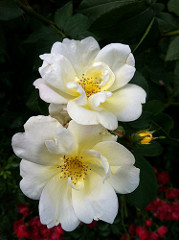

In [29]:
roses = list(data_dir.glob('roses/*'))
print(len(roses))
PIL.Image.open(str(roses[0]))

641


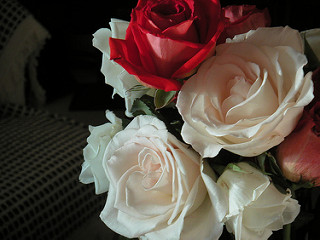

In [30]:
roses = list(data_dir.glob('roses/*'))
print(len(roses))
PIL.Image.open(str(roses[1]))

In [31]:
#  tf.keras.utils.image_dataset_from_directory 유틸리티를 사용하여 디스크에서 이런 이미지를 로드

# 데이터 셋 만들기
# 1. 로더를 위한 매개변수 정의
batch_size = 32
img_height = 180
img_width = 180


In [32]:
# 데이터셋 로드 (이미지 중 훈련 이미지는 80%, 20%는 유효성 검증)
train_ds = tf.keras. utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [33]:
val_ds = tf.keras. utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [34]:
# ds에 있는 class_names 속성으로 클래스 이름을 알아올 수 있음
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


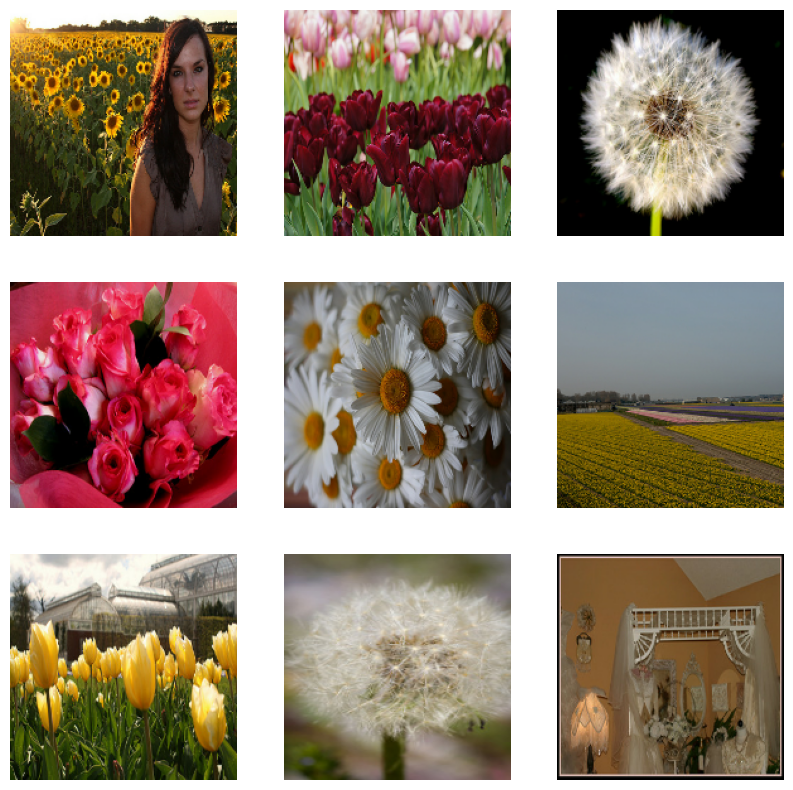

In [39]:
# 데이터 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # print(image[i].numpy().astype("uint8")) # uint8? unsigned int 8비트
        plt.imshow(images[i].numpy().astype("uint8"))   # numpy(): 데이터를 numpy.ndarray 로 변환
        plt.axis("off")

In [ ]:
# 이렇게 만들어지는 데이터셋은 모델을 model.fit() 할 때에 훈련용으로 사용이 가능해요.

In [37]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [40]:
# 데이터 표준화하기
# RGB 채널 값은 [0, 255] 범위에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다.

# 여기에서 tf.keras.layers.Rescaling을 사용하여 값을 [0 ~ 1] 범위로 표준화합니다.
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [41]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
# 참고: 픽셀 값을 [-1,1]로 조정하려면 대신 tf.keras.layers.Rescaling(1./127.5, offset=-1)을 작성할 수 있습니다

0.009804222 1.0


In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
# 모델 훈련하기

num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [46]:
# 모델 훈련
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.3695 - loss: 1.4448 - val_accuracy: 0.5327 - val_loss: 1.1060
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.5926 - loss: 1.0068 - val_accuracy: 0.5967 - val_loss: 1.0052
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.6612 - loss: 0.8595 - val_accuracy: 0.6267 - val_loss: 0.9257
